# TP2 : Extraction d’Information et Traitement Automatique de Corpus

## Marouane BIDOUKHACH STIC

Ce notebook regroupe toutes les étapes du TP d'extraction d'information appliqué au sous-corpus CAMille pour une année spécifique.

### Étapes incluses:
- Extraction de mots-clés
- Génération d'un nuage de mots
- Identification d'entités nommées
- Analyse de sentiment simplifiée


---

### ==== PARTIE 0 — CONFIG & IMPORTS ====

In [ ]:


import os, re, glob, sys, subprocess, importlib
from collections import Counter
from pathlib import Path

# Année d'analyse
YEAR = 1945
# Chemin 
DATA_DIR = r"C:\Users\bidou\Nouveau dossier\tac\data\txt"
OUTPUT_DIR = f"results/{YEAR}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fonction pour installer une librairie si absente
def ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
    except Exception:
        print(f"[install] {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Installations
ensure("yake")
ensure("spacy")
ensure("textblob")
ensure("wordcloud")
ensure("pandas")
ensure("numpy")
ensure("matplotlib")
try:
    importlib.import_module("textblob_fr")
except Exception:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob-fr"])
    except:
        print("(!) textblob-fr non installé, fallback EN moins précis pour le FR")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS as WC_STOP
import yake, spacy
from textblob import TextBlob

plt.rcParams["figure.figsize"] = (10,6)

# Chargement modèle SpaCy FR
def load_spacy_fr():
    try:
        return spacy.load("fr_core_news_md")
    except:
        try:
            subprocess.check_call([sys.executable, "-m", "spacy", "download", "fr_core_news_md"])
            return spacy.load("fr_core_news_md")
        except:
            subprocess.check_call([sys.executable, "-m", "spacy", "download", "fr_core_news_sm"])
            return spacy.load("fr_core_news_sm")

nlp = load_spacy_fr()


### ==== PARTIE 1 — Chargement corpus ====

In [ ]:


def year_in_text(s, year):
    return str(year) in s

def year_in_filename(path, year):
    y = re.findall(r'\b(18|19)\d{2}\b', os.path.basename(path))
    return str(year) in y if y else False

def file_belongs_to_year(path, year):
    if year_in_filename(path, year):
        return True
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            head = f.read(4096)
        return year_in_text(head, year)
    except:
        return False

def load_texts_for_year(data_dir, year):
    paths = glob.glob(os.path.join(data_dir, "**", "*.txt"), recursive=True)
    year_paths = [p for p in paths if file_belongs_to_year(p, year)]
    texts = []
    for p in year_paths:
        try:
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                texts.append(f.read())
        except:
            pass
    return year_paths, texts

paths, texts = load_texts_for_year(DATA_DIR, YEAR)
print(f"Articles chargés pour {YEAR} :", len(paths))


In [ ]:
# ==== PARTIE 2 — Nettoyage & stopwords ====

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"[\d]", " ", s)
    s = re.sub(r"[\-—–_/\\]", " ", s)
    s = re.sub(r"[\\.,;:!?()\\[\\]{}'\"«»“”]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

spacy_stop = nlp.Defaults.stop_words if hasattr(nlp.Defaults, "stop_words") else set()
extra_stop = {
    "mai","juin","septembre","janvier","février","mars","avril","juillet","aout","août","octobre","novembre","décembre",
    "l","d","c","mm","aujourd","hui","année","années","belgique","belge","bruxelles","journal","article",
    "hier","aujourd'hui","demain","fois","jour","jours","annonce","déclare","communique","presse"
}
STOPWORDS_ITER_1 = set(spacy_stop) | extra_stop

corpus_clean = [normalize_text(t) for t in texts]


### Étape 3 : Identification manuelle des entités nommées

                keyword     score
0                   rue  0.000008
1  ecrire agence rossel  0.000010
2            rue royale  0.000014
3                rossel  0.000020
4         agence rossel  0.000022
5                   dem  0.000023
6            faire part  0.000023
7       avis tient lieu  0.000046
8                   tél  0.000050
9               rue van  0.000051


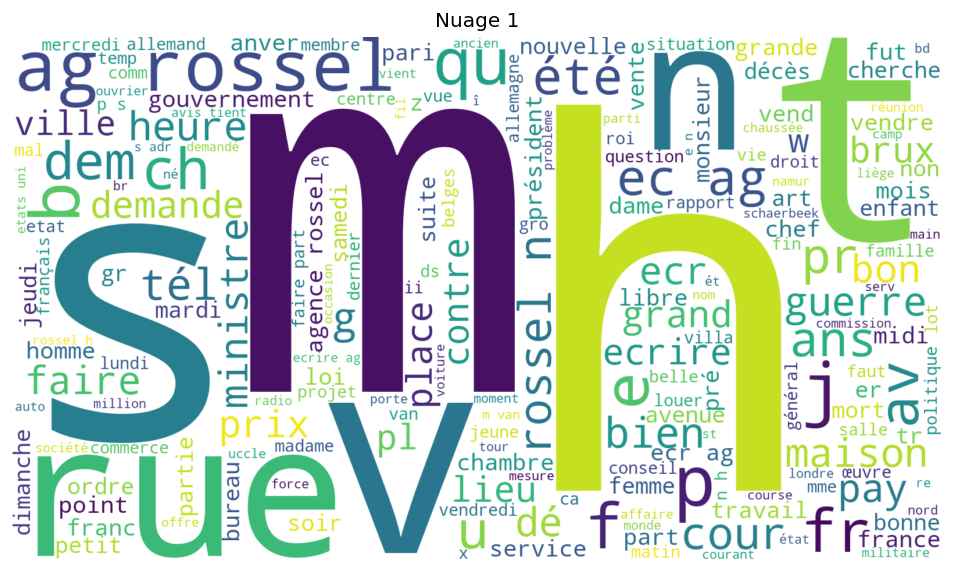

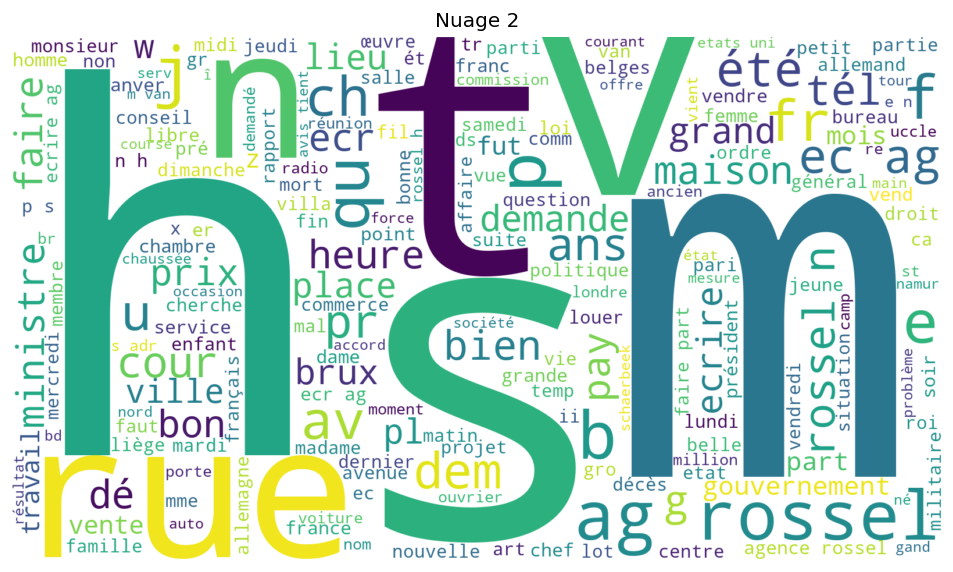

In [26]:
# ==== PARTIE 3 — Mots-clés + nuages ====

def extract_keywords_yake(docs, topk=300, max_ngram=3):
    kw_extractor = yake.KeywordExtractor(lan="fr", n=max_ngram, top=topk, features=None)
    joined = "\n".join(docs)
    keywords = kw_extractor.extract_keywords(joined)
    df = pd.DataFrame(keywords, columns=["keyword", "score"]).sort_values("score")
    return df

def clean_keywords(df, stopset):
    cleaned, seen = [], set()
    for kw, score in df.values:
        k = " ".join([w for w in normalize_text(kw).split() if (w not in stopset and len(w) > 2)])
        if not k or k in seen:
            continue
        seen.add(k)
        cleaned.append((k, score))
    return pd.DataFrame(cleaned, columns=["keyword","score"]).sort_values("score")

kw_df_raw = extract_keywords_yake(corpus_clean)
kw_df_clean1 = clean_keywords(kw_df_raw, STOPWORDS_ITER_1)
print(kw_df_clean1.head(10))

# Nuages
def build_wordcloud(texts, extra_stop=set(), outpath=None, title=None):
    stopset = set(WC_STOP) | STOPWORDS_ITER_1 | set(extra_stop)
    txt = " ".join(texts)
    wc = WordCloud(width=1600, height=900, stopwords=stopset, background_color="white")
    wc.generate(txt)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if title: plt.title(title)
    if outpath: wc.to_file(outpath)

# Itération 1
build_wordcloud(corpus_clean, outpath=f"{OUTPUT_DIR}/wordcloud_iter1.png", title="Nuage 1")

# Itération 2
noise_terms = {"pour","avec","sans","dans","entre","contre","ainsi","toute","tous","toutes",
               "capitulation","guerre","monde"}
build_wordcloud(corpus_clean, extra_stop=noise_terms,
                outpath=f"{OUTPUT_DIR}/wordcloud_iter2.png", title="Nuage 2")


          keyword     score
0           tient  0.000046
1        l’agence  0.000081
2            état  0.000110
3          guerre  0.000139
4            d’un  0.000146
5             ecr  0.000146
6           d’une  0.000147
7           qu’il  0.000161
8           c’est  0.000168
9            bons  0.000169
10          bonne  0.000169
11  présent tient  0.000171
12       ecr. ag.  0.000173
13          cours  0.000178
14           pays  0.000179
15           dem.  0.000187
16         heures  0.000188
17       monsieur  0.000192
18            ag.  0.000213
19        général  0.000225
[save] wordcloud_iter3.png


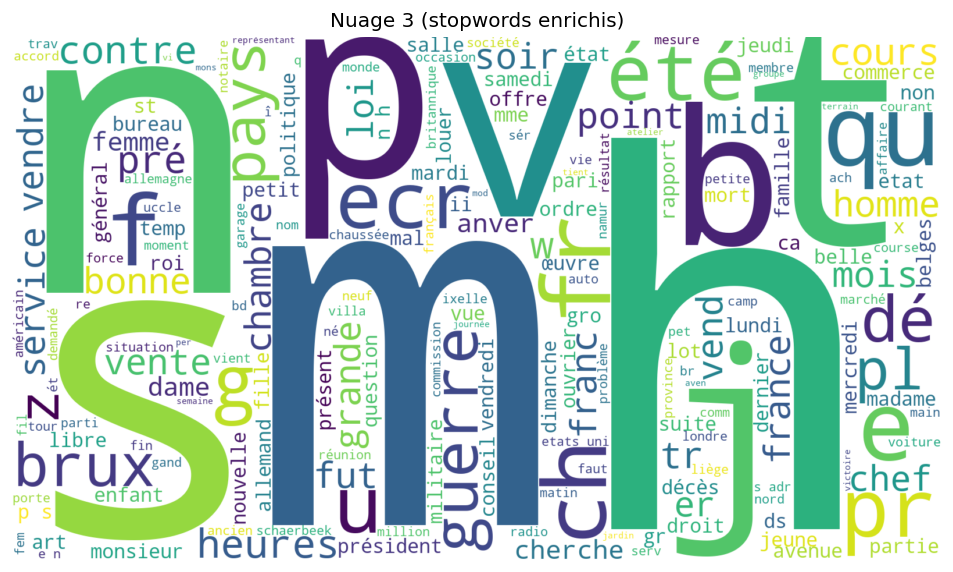

In [30]:
# ==== NETTOYAGE SUPPLÉMENTAIRE ====

# Liste de mots parasites à supprimer (liés aux adresses, annonces, mots trop génériques)
parasites_suppl = {
    "rue","royale","van","rossel","agence","ag","tél","tel","dem","avis","faire","part","lieu",
    "ec","ecrire","écrire","prix","bon","bien","grand","demande","cour","ans","av","pay",
    "maison","heure","place","ville","centre","quartier","travail","projet","ministre","gouvernement"
}

# On ajoute ces parasites à la liste de stopwords
STOPWORDS_ITER_1 |= parasites_suppl

# On relance le nettoyage des mots-clés
kw_df_clean2 = clean_keywords(kw_df_raw, STOPWORDS_ITER_1)
print(kw_df_clean2.head(20))  # Top 20 après nettoyage

# On génère un nouveau nuage plus propre
build_wordcloud(corpus_clean, extra_stop=parasites_suppl,
                outpath=f"{OUTPUT_DIR}/wordcloud_iter3.png",
                title="Nuage 3 (stopwords enrichis)")
print("[save] wordcloud_iter3.png")


### Étape 4 : Analyse de sentiment des phrases sélectionnées

In [31]:
# ==== PARTIE 4 — Extraction d’entités nommées (SpaCy) ====
# Prérequis : variables `texts`, `OUTPUT_DIR`, et l'objet spaCy `nlp` déjà définis.

import pandas as pd
import re

# 1) Fonction d'extraction
def extract_entities_spacy(docs, labels=("PERSON","ORG","GPE")):
    ents = []
    for doc in nlp.pipe(docs, disable=["tagger","lemmatizer","morphologizer"]):
        for e in doc.ents:
            if e.label_ in labels:
                ents.append((e.text.strip(), e.label_))
    return pd.DataFrame(ents, columns=["text","label"])

# 2) Normalisation basique
def norm_ent(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    # on enlève ponctuation en bord
    s = re.sub(r"^[\"'«»“”\\(\\)\\[\\]\\{\\},.:;!?-]+|[\"'«»“”\\(\\)\\[\\]\\{\\},.:;!?-]+$", "", s)
    return s

# 3) Liste de parasites à exclure (bruit d'annonces/abréviations)
ENT_STOP = {
    # abréviations fréquentes/bruit
    "dem","bur","adr","fem","mén","ec","av","tel","tél","ag","rossel","agence rossel",
    "mm","mr","mme","m.","s.","st","bd","n°","no",
    # termes génériques souvent mal étiquetés comme ORG
    "rue","avenue","chaussée","place","bureau","service","conseil",  # <- garde "Conseil" si tu le veux, retire-le ici
}

# 4) Extraction brute
ner_df = extract_entities_spacy(texts)

# 5) Nettoyage
if len(ner_df):
    ner_df["text_norm"] = ner_df["text"].apply(norm_ent)
    ner_df["text_low"]  = ner_df["text_norm"].str.lower()

    # critères de bruit : vide, < 3 chars, quasi tout en chiffres, dans ENT_STOP
    mask_good = (
        (ner_df["text_norm"].str.len() >= 3) &
        (~ner_df["text_low"].isin(ENT_STOP)) &
        (~ner_df["text_norm"].str.fullmatch(r"[\\W_]+")) &
        (~ner_df["text_norm"].str.fullmatch(r"\\d+[\\W_\\d]*"))
    )
    ner_df_clean = ner_df[mask_good].copy()

    # 6) Agrégation : Top 20 par type (PERSON/ORG/GPE)
    top_ents = (ner_df_clean
                .groupby(["label","text_norm"])
                .size()
                .reset_index(name="count")
                .sort_values(["label","count"], ascending=[True, False]))

    top20_by_label = top_ents.groupby("label").head(20).reset_index(drop=True)

    # 7) Exports
    top_ents.to_csv(f"{OUTPUT_DIR}/entities_all_clean.csv", index=False, encoding="utf-8")
    top20_by_label.to_csv(f"{OUTPUT_DIR}/entities_top20_clean.csv", index=False, encoding="utf-8")

    # 8) Aperçu console
    print("== TOP 20 PERSON ==")
    print(top20_by_label[top20_by_label["label"]=="PERSON"].head(20).to_string(index=False))
    print("\n== TOP 20 ORG ==")
    print(top20_by_label[top20_by_label["label"]=="ORG"].head(20).to_string(index=False))
    print("\n== TOP 20 GPE ==")
    print(top20_by_label[top20_by_label["label"]=="GPE"].head(20).to_string(index=False))

else:
    print("Aucune entité détectée.")


== TOP 20 PERSON ==
Empty DataFrame
Columns: [label, text_norm, count]
Index: []

== TOP 20 ORG ==
label    text_norm  count
  ORG      Chambre    112
  ORG       Reuter    106
  ORG        Sénat     63
  ORG    Parlement     62
  ORG     K ON DEM     54
  ORG         trav     53
  ORG         Inst     41
  ORG    Téléphone     41
  ORG     GALERIES     40
  ORG          hom     38
  ORG         Ford     33
  ORG          fac     33
  ORG      Gestapo     31
  ORG         exlg     31
  ORG     Finances     30
  ORG          enf     30
  ORG          com     29
  ORG       Import     28
  ORG Constitution     26
  ORG        K DEM     26

== TOP 20 GPE ==
Empty DataFrame
Columns: [label, text_norm, count]
Index: []


In [32]:
# ==== PARTIE 5 — Sentiments ====

sentences = []
for doc in nlp.pipe(texts, disable=["ner","tagger","lemmatizer","morphologizer"]):
    sentences.extend([s.text.strip() for s in doc.sents if len(s.text.strip()) > 20])

top_keywords = set(kw_df_clean1["keyword"].head(50))
ent_terms = set(top_ents["text_norm"].head(50)) if len(top_ents) else set()

def relevance_score(sent):
    s_norm = normalize_text(sent)
    score = 0
    for kw in top_keywords:
        if re.search(rf"\b{re.escape(kw)}\b", s_norm):
            score += 2
    for ent in ent_terms:
        if re.search(rf"\b{re.escape(normalize_text(ent))}\b", s_norm):
            score += 3
    return score

scored = sorted([(s, relevance_score(s)) for s in sentences], key=lambda x: x[1], reverse=True)

selected, seen = [], set()
for s, sc in scored:
    sig = " ".join(normalize_text(s).split()[:8])
    if sig in seen or sc == 0:
        continue
    seen.add(sig)
    selected.append(s)
    if len(selected) == 10:
        break

# Sentiment FR si dispo
try:
    from textblob_fr import PatternTagger, PatternAnalyzer
    def fr_sentiment(s):
        return TextBlob(s, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
except:
    def fr_sentiment(s):
        return TextBlob(s).sentiment

rows = []
for i, s in enumerate(selected, 1):
    pol, subj = fr_sentiment(s)
    rows.append({"#": i, "phrase": s, "polarite": float(pol), "subjectivite": float(subj)})

sent_df = pd.DataFrame(rows)
print(sent_df)
sent_df.to_csv(f"{OUTPUT_DIR}/sentiments_10phrases.csv", index=False)


    #                                             phrase  polarite  \
0   1  Ecrire A l’Agence Rossel au n» 43142 H. ‘ Impo...  0.240000   
1   2  firme cherchant agent général Ecrira â l’Agenc...  0.000000   
2   3  Ecrire à l’AGENCE ROSSEL N« 415 M. FIRME désir...  0.000000   
3   4  â l’Agence Rossel au n® 1410 H. ON DEMANDE SEC...  0.000000   
4   5  : 27, rue Camu- sel, à 9 h. 30- Le présent avi...  0.120000   
5   6  » Pas d'accord secret, déclare M. de Foy D’aut... -0.032857   
6   7              Ecrire Agence Rossel n®5S935H IMPORT.  0.000000   
7   8  Le Sénat en arrive aux interpellations de MM. ...  0.130000   
8   9  Ecrire à l'Agence Rossel au n. 55348H FIRME prod.  0.000000   
9  10          Ecrire Agence Rossel n« 52S13A Bons ouvr!  0.875000   

   subjectivite  
0      0.275000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.150000  
5      0.142857  
6      0.000000  
7      0.157143  
8      0.000000  
9      0.700000  
